In [1]:
import pandas as pd

## Functions

#### Merging

In [2]:
MERGE_COLUMNS = ["year", "SA2 code"]

def get_merged_df(new_df, final_df):
    if (final_df.empty):
        return new_df

    print(new_df.columns)
    print(final_df.columns)

    # get the attributes used for the merge
    merge_columns = list(set(new_df.columns) & set(MERGE_COLUMNS) & set(final_df.columns))

    print(merge_columns)

    # merge columns
    merged_df = pd.merge(final_df, new_df, on=merge_columns, how="inner")

    if ("year" in new_df):
        print(new_df["year"].unique())
        print(final_df["year"].unique())

    # check if any columns lost
    print(f"lost {final_df.shape[0] - merged_df.shape[0]} out of {final_df.shape[0]} records")
    
    return merged_df

### General

In [3]:
def rename_dict(df, rename_dict, keep_columns):
    # get the renamed dictionary
    new_column_names = list(df.columns.copy())
    for index, new_name in rename_dict.items():
        new_column_names[index - 1] = new_name
    df.columns = new_column_names

    # drop the columns not of interest
    keep_columns = [x-1 for x in keep_columns]
    df = df.iloc[:, keep_columns]

    return df

### Column and imputation

In [4]:
def impute_previous(columns, na):
    flat_column_list = [[group[i] for group in columns] for i in range(len(columns[0]))]

    column_dataframe = pd.DataFrame(flat_column_list)

    column_dataframe = column_dataframe.applymap(lambda x: None if (not x) or (na in str(x)) else x)

    column_dataframe = column_dataframe.T.ffill().T

    flat_column_list = column_dataframe.to_numpy()

    return flat_column_list

In [5]:
def fill_columns(df, column_dict, na="Unnamed"):
    columns = list(df.columns)

    for index, new_column in column_dict.items():
        columns[index] = new_column

    if (type(df.columns) == pd.MultiIndex):
        flat_column_list = impute_previous(columns, na)

        df.columns = pd.MultiIndex.from_arrays(flat_column_list)
    
    else:
        df.columns = columns

    return df

## Document notes + set up

- Note that the final file produced, each timestamp will correspond to the growth from the previous time stamp
  - For example, if the population is 1000 in the 2022-03 quarter, then 1100 in the 2022-06 quater, then the value for the 2022-06 quarter population growth is 10%
  - Similarly for inflation, measures the change from previous quarter

In [6]:
RELATIVE_PATH = "../../data/landing/"

## Economic by Region (check)

In [7]:
def filter_victoria(df, column_name):
    region_mask = ~df[column_name].str.isnumeric()

    # get the region indexes and names
    regions_index, regions_names = list(df[region_mask].index), list(df[region_mask][column_name].values)

    # find the index for victoria in the list
    index_victoria = regions_names.index("Victoria")

    # reference the mask between victoria and the next index
    df = df.loc[regions_index[index_victoria] + 1: regions_index[index_victoria + 1] - 1]

    return df

### Geography summary

- Note the income of a given year (say 2020) is acutally from july year before to jun next year (July 2019 to June 2020)
  - Because the data was given as financial years

In [8]:
COLUMNS_DICT_INCOME_GEOGRAPHY = {
    0: ("SA2 code",None),
    1: ("SA2 name",None)
}

In [9]:
# get the df
income_region = pd.read_csv("../../data/landing/economic_by_region/income_by_geography_2016_2023.csv", header=[0, 1])

# fill empty columns for the join
income_region = fill_columns(income_region, COLUMNS_DICT_INCOME_GEOGRAPHY)

# only look at columns of interest
income_region = filter_victoria(income_region, ("SA2 code", None))

# create a massive list of stuff, each record has a unique year, location and measure
income_region = income_region.melt(id_vars=income_region.columns.to_list()[:2], 
                                   value_vars = income_region.columns.to_list()[2:],
                                   var_name=["Measure", "Year"],
                                   value_name="Value")

# make it so each record only has a unique year and location
income_region = income_region.pivot(index=list(income_region.columns[:2]) + ["Year"], columns="Measure", values="Value")
income_region = income_region.reset_index()
income_region.columns = [x[0] for x in income_region.columns[:2]] + list(income_region.columns[2:])

FileNotFoundError: [Errno 2] No such file or directory: '../../data/landing/economic_by_region/income_by_geography_2016_2023.csv'

In [ ]:
# filter and rename
NEW_NAMES = {
    3: "year",
    4: "economic: number of earners",
    6: "economic: median income", 
    7: "economic: median age of earners"
}
KEEP_COLUMNS = [1, 2, 3, 4, 6, 7]

income_region = rename_dict(income_region, NEW_NAMES, KEEP_COLUMNS)
print(income_region.shape[0])
income_region.head(5)

2610


,SA2 code,SA2 name,year,economic: number of earners,economic: median income,economic: median age of earners
0,201011001,Alfredton,2016-17,"7,117","50,596",42
1,201011001,Alfredton,2017-18,"7,558","52,448",42
2,201011001,Alfredton,2018-19,"7,987","53,932",42
3,201011001,Alfredton,2019-20,"8,665","55,204",41
4,201011001,Alfredton,2020-21,"9,438","58,036",41


In [ ]:
import numpy as np

MEASURE_COLUMNS = income_region.columns[3:]

# drop any na values in measure columns
income_region = income_region.replace("np", np.nan)
income_region = income_region.dropna(subset=MEASURE_COLUMNS, how="any")
income_region.shape[0]

# convert to first year
income_region["year"] = income_region["year"].apply(lambda x: x[:4]).astype(int)

# get numeric columns
for measure_column in MEASURE_COLUMNS:
    income_region[measure_column] = pd.to_numeric(income_region[measure_column].str.replace(',', ''))

print(income_region.shape[0])
income_region.head(5)

2602


,SA2 code,SA2 name,year,economic: number of earners,economic: median income,economic: median age of earners
0,201011001,Alfredton,2016,7117,50596,42
1,201011001,Alfredton,2017,7558,52448,42
2,201011001,Alfredton,2018,7987,53932,42
3,201011001,Alfredton,2019,8665,55204,41
4,201011001,Alfredton,2020,9438,58036,41


In [ ]:
# REMOVE SA2 regions without all the years

# get the regions with 5 counts
SA2_year_counts = income_region.groupby(["SA2 code"])["year"].count()
SA2_regions = SA2_year_counts[SA2_year_counts == 5].index

# remove anything doesn't have these from the final_df
income_region = income_region[income_region["SA2 code"].isin(SA2_regions)]
income_region.shape[0]

2595

In [ ]:
START_YEAR = 2016
END_YEAR = 2021

for curr_year in range(START_YEAR, END_YEAR):
    # get the years
    curr_year_df = income_region[(income_region["year"] == curr_year)]
    both_years_df = income_region[(income_region["year"] == curr_year) | (income_region["year"] == curr_year + 1)]

    # average using the next
    avg_year_df = both_years_df[["SA2 code"] + list(MEASURE_COLUMNS)].groupby("SA2 code").mean()

    # only concerned about SA2 regions of current year
    avg_year_df = avg_year_df.loc[curr_year_df["SA2 code"].unique()]

    # get the indices of the original year
    avg_year_df.index = curr_year_df.index

    # assign the new chunk
    income_region.loc[curr_year_df.index, MEASURE_COLUMNS] = avg_year_df

income_region.head(5)


,SA2 code,SA2 name,year,economic: number of earners,economic: median income,economic: median age of earners
0,201011001,Alfredton,2016,7337.5,51522.0,42.0
1,201011001,Alfredton,2017,7772.5,53190.0,42.0
2,201011001,Alfredton,2018,8326.0,54568.0,41.5
3,201011001,Alfredton,2019,9051.5,56620.0,41.0
4,201011001,Alfredton,2020,9438.0,58036.0,41.0


In [ ]:
new_df = income_region.sort_values(by=["SA2 code", "year"])
#new_df["growth"] = new_df["economic: median income"].pct_change()

In [ ]:
new_df

,SA2 code,SA2 name,year,economic: number of earners,economic: median income,economic: median age of earners
0,201011001,Alfredton,2016,7337.5,51522.0,42.0
1,201011001,Alfredton,2017,7772.5,53190.0,42.0
2,201011001,Alfredton,2018,8326.0,54568.0,41.5
3,201011001,Alfredton,2019,9051.5,56620.0,41.0
4,201011001,Alfredton,2020,9438.0,58036.0,41.0
...,...,...,...,...,...,...
2605,217041480,Warrnambool - South,2016,7675.5,44437.5,44.0
2606,217041480,Warrnambool - South,2017,7894.0,46484.0,44.0
2607,217041480,Warrnambool - South,2018,8073.5,48161.0,44.0
2608,217041480,Warrnambool - South,2019,8160.5,50719.5,44.0


In [ ]:
new_df["growth"] = new_df.groupby("SA2 code")["economic: median income"].apply(lambda x: x.pct_change())

/tmp/ipykernel_50200/1861132978.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  new_df["growth"] = new_df.groupby("SA2 code")["economic: median income"].apply(lambda x: x.pct_change())


In [ ]:
VIEW = 23
SIZE = 30

new_df.iloc[VIEW * SIZE: (VIEW + 1) * SIZE + 1]

,SA2 code,SA2 name,year,economic: number of earners,economic: median income,economic: median age of earners,growth
700,206041508,Southbank (West) - South Wharf,2016,4694.0,53387.0,33.5,NaN
701,206041508,Southbank (West) - South Wharf,2017,4726.5,56092.0,34.0,0.050668
702,206041508,Southbank (West) - South Wharf,2018,4868.0,57043.5,34.0,0.016963
703,206041508,Southbank (West) - South Wharf,2019,4905.0,58321.5,34.0,0.022404
704,206041508,Southbank (West) - South Wharf,2020,4852.0,59683.0,34.0,0.023345
705,206041509,Southbank - East,2016,9161.5,50043.0,31.0,NaN
706,206041509,Southbank - East,2017,10007.5,51509.0,31.0,0.029295
707,206041509,Southbank - East,2018,10953.0,51740.0,31.0,0.004485
708,206041509,Southbank - East,2019,11727.0,52572.0,31.5,0.016080
709,206041509,Southbank - East,2020,11842.0,54392.0,32.0,0.034619


### Distribution

In [ ]:
# get the economic distribtuion
economic_distribution = pd.read_csv(RELATIVE_PATH + "/economic_by_region/income_distribution_by_geography_2021.csv", header=0)
economic_distribution = economic_distribution.drop(0)
economic_distribution.head(5)

# rename and filter
NEW_NAMES = {
    1: "SA2 code", 
    12: "economic: gini coefficient",
    13: "economic: top 1% suburb",
    14: "economic: top 5% suburb"
}
KEEP_COLUMNS = [1, 12, 13, 14]
economic_distribution = rename_dict(economic_distribution, NEW_NAMES, KEEP_COLUMNS)

print(economic_distribution.dtypes)
economic_distribution.head()

SA2 code                      object
economic: gini coefficient    object
economic: top 1% suburb       object
economic: top 5% suburb       object
dtype: object


,SA2 code,economic: gini coefficient,economic: top 1% suburb,economic: top 5% suburb
1,Australia,0.483,9.8,22.5
2,New South Wales,0.497,11.2,24.3
3,101021007,0.615,21.2,32.6
4,101021008,0.365,4.4,14.5
5,101021009,0.368,4.6,14.7


In [ ]:
# check no Nan values
economic_distribution.isna().any(axis=1).sum()

0

## Economic (Check)

#### Inflation (Check)

- Basically, remember that it is annualized
- Will therefore calculate the average percent change from the previous year
  - Note December the year before, + march + Jun + Sep of the year will be used for the average

In [ ]:
# donwload inflation
inflation = pd.read_csv(RELATIVE_PATH + "economic/inflation.csv")

# rename the columns
NEW_NAMES = {1: "year", 2: "economic: CPI", 3: "economic: trimmed mean"}
KEEP_COLUMNS = list(range(3))
inflation = rename_dict(inflation, NEW_NAMES, KEEP_COLUMNS)

print(inflation.dtypes)
inflation.tail(10)

economic: trimmed mean    float64
year                       object
economic: CPI             float64
dtype: object


,economic: trimmed mean,year,economic: CPI
31,3.8,Mar-22,5.1
32,4.9,Jun-22,6.1
33,6.0,Sep-22,7.3
34,6.8,Dec-22,7.8
35,6.5,Mar-23,7.0
36,5.8,Jun-23,6.0
37,5.1,Sep-23,5.4
38,4.1,Dec-23,4.1
39,4.0,Mar-24,3.6
40,3.9,Jun-24,3.8


In [ ]:
# split up the month and the year
inflation[["month", "year"]] = inflation["year"].str.split("-", expand=True)

# get the actual year
inflation["year"] = inflation["year"].astype(int) + 2000
inflation["economic: trimmed mean"] = inflation["economic: trimmed mean"].astype(float)

# if december, increase year by one
inflation.loc[inflation["month"] == "Dec", "year"] += 1

# find all years with 4 months, and remove years not included in this list
year_list = inflation["year"].value_counts()[inflation["year"].value_counts() == 4].index
inflation = inflation[inflation["year"].isin(year_list)]

# calculate the actual percentage
inflation["economic: trimmed mean"] = inflation["economic: trimmed mean"].apply(lambda x: (x/100)/4 + 1)
inflation = inflation.drop(["month", "economic: CPI"], axis=1)
inflation.tail(5)

,economic: trimmed mean,year
33,1.01500,2022
34,1.01700,2023
35,1.01625,2023
36,1.01450,2023
37,1.01275,2023


In [ ]:
# group by year
inflation = inflation.groupby("year")["economic: trimmed mean"].apply(lambda x: x.prod())

# reset the index
inflation = inflation.reset_index()

# convert back to percentage
inflation["economic: trimmed mean"] = inflation["economic: trimmed mean"].apply(lambda x: (x-1)*100)

inflation

,year,economic: trimmed mean
0,2015,2.218210
1,2016,1.761464
2,2017,1.660228
3,2018,1.710868
4,2019,1.609607
5,2020,1.432587
6,2021,1.508263
7,2022,4.393613
8,2023,6.188091


#### Interest rates (Check)

Have decided only to take the variable interest rate for standard owners (as this is most reflective of normal people)

In [ ]:
# download the lending data
lending = pd.read_csv(RELATIVE_PATH + "economic/lending.csv")

# rename the columns
NEW_NAMES = {1: "year", 4: "economic: variable interest rate"}
KEEP_COLUMNS = [1, 4]
lending = rename_dict(lending, NEW_NAMES, KEEP_COLUMNS)

print(lending.dtypes)
lending.tail(5)

year                                 object
economic: variable interest rate    float64
dtype: object


,year,economic: variable interest rate
783,2024-04-30,8.77
784,2024-05-31,8.77
785,2024-06-30,8.77
786,2024-07-31,8.77
787,2024-08-31,8.77


- Basically want to take the average of all the records for each year
- Seems to make most sense to use the actual percentage (above 100%) rather than say 1.02

In [ ]:
# get the year as an integer for each record
lending["year"] = lending["year"].apply(lambda x: int(x[:4]))

# remove records before 2000
lending = lending[lending["year"] >= 2000]

# take the average for each year
lending = lending.groupby("year")["economic: variable interest rate"].apply(lambda x: x.mean()).reset_index()

# calculate the percentage change
lending["economic: variable interest rate"] = lending["economic: variable interest rate"].pct_change()

lending.head(5)

,year,economic: variable interest rate
0,2000,NaN
1,2001,-0.111854
2,2002,-0.069832
3,2003,0.039170
4,2004,0.065963


### GDP (Check)

- GDP is basically add from each year (even tho this misses out on a small amount of gdp growth)
- Same process as inflation, except this shows the quarterly growth instead

In [ ]:
# download the lending data
gdp = pd.read_csv(RELATIVE_PATH + "economic/gdp.csv")

# rename the columns
NEW_NAMES = {1: "year", 3: "economic: gdp annual"}
KEEP_COLUMNS = [1, 3]
gdp = rename_dict(gdp, NEW_NAMES, KEEP_COLUMNS)

print(gdp.dtypes)
gdp.tail(5)

year                     object
economic: gdp annual    float64
dtype: object


,year,economic: gdp annual
28,Jun-23,0.5
29,Sep-23,0.3
30,Dec-23,0.2
31,Mar-24,0.2
32,Jun-24,0.2


In [ ]:
# split up the month and the year
gdp[["month", "year"]] = gdp["year"].str.split("-", expand=True)

# get the actual year
gdp["year"] = gdp["year"].astype(int) + 2000
gdp["economic: gdp annual"] = gdp["economic: gdp annual"].astype(float)

# if december, increase year by one
gdp.loc[gdp["month"] == "Dec", "year"] += 1

# find all years with 4 months, and remove years not included in this list
year_list = gdp["year"].value_counts()[gdp["year"].value_counts() == 4].index
gdp = gdp[gdp["year"].isin(year_list)]

# calculate the actual percentage
gdp["economic: gdp annual"] = gdp["economic: gdp annual"].apply(lambda x: (x/100) + 1)
gdp = gdp.drop(["month"], axis=1)
gdp.head(5)

,year,economic: gdp annual
2,2017,1.012
3,2017,1.003
4,2017,1.006
5,2017,1.009
6,2018,1.004


In [ ]:
# group by year
gdp = gdp.groupby("year")["economic: gdp annual"].apply(lambda x: x.prod())

# reset the index
gdp = gdp.reset_index()

# convert back to percentage
gdp["economic: gdp annual"] = gdp["economic: gdp annual"].apply(lambda x: (x-1)*100)

gdp

,year,economic: gdp annual
0,2017,3.031635
1,2018,2.522283
2,2019,1.710125
3,2020,-3.145769
4,2021,4.807871
5,2022,5.680575
6,2023,2.014646


## Population (Check)

Greater Capital City Statistical Area (GCCSA) code and Greater Capital City Statistical Area (GCCSA) name

### Getting data

In [ ]:
import os
import pandas as pd
import numpy as np

# Use the absolute path to the file
vic_population_filepath = RELATIVE_PATH + 'population/age_demos.csv'

# Read the CSV file
vic_population_df = pd.read_csv(vic_population_filepath, header=[0, 1])

# drop the first level
vic_population_df.columns = vic_population_df.columns.droplevel(0)

# rename the columns
NEW_NAMES = {1: "year", 3: "state", 10: "SA2 code", len(vic_population_df.columns): "population: total"}
KEEP_COLUMNS = list(NEW_NAMES.keys())
vic_population_df = rename_dict(vic_population_df, NEW_NAMES, KEEP_COLUMNS)

print(vic_population_df.dtypes)
vic_population_df.head(5)


year                   int64
state                 object
SA2 code             float64
population: total    float64
dtype: object


,year,state,SA2 code,population: total
0,2001,New South Wales,101021007.0,2760.0
1,2001,New South Wales,101021008.0,9129.0
2,2001,New South Wales,101021009.0,9717.0
3,2001,New South Wales,101021010.0,3925.0
4,2001,New South Wales,101021012.0,9425.0


In [ ]:
# Filter for Victoria entries
vic_population_df = vic_population_df[vic_population_df['state'] == 'Victoria']

# sort the values
vic_population_df =  vic_population_df.sort_values(by=["SA2 code", "year"])

# calculate the percentage change
vic_population_df["population: growth"] = vic_population_df.groupby("SA2 code")["population: total"] \
                                        .pct_change() * 100

# remove missing values
vic_population_df = vic_population_df[~vic_population_df["population: growth"].isna()]

# convert to string for easy
vic_population_df["SA2 code"] = vic_population_df["SA2 code"].astype(int).astype(str)

# drop columns not of interest
vic_population_df = vic_population_df.drop(columns=["state"])

vic_population_df.head(5)


,year,SA2 code,population: total,population: growth
3096,2002,201011001,6092.0,5.837387
5550,2003,201011001,6293.0,3.299409
8004,2004,201011001,6480.0,2.971556
10458,2005,201011001,6648.0,2.592593
12912,2006,201011001,6761.0,1.699759


### Population future

### Nigel other stuff

In [ ]:
# Save the new dataframe to a CSV file in the curated folder
curated_folder = '../../data/curated/population/'
os.makedirs(curated_folder, exist_ok=True)

# Save the dataframe to a CSV file
curated_csv_path = os.path.join(curated_folder, 'vic_population_df.csv')
vic_population_df.to_csv(curated_csv_path, index=False)

In [ ]:
sa2_to_rental_suburb_groups_filepath = '../../data/raw/location/sa2_to_rental_suburb_groups.csv'
sa2_to_rental_suburb_groups_df = pd.read_csv(sa2_to_rental_suburb_groups_filepath)

## Merging Together

In [ ]:
# all the frames to merge
all_frames = [income_region, economic_distribution, inflation, lending, gdp, vic_population_df]


merged_df = pd.DataFrame({})
for frame in all_frames:
    merged_df = get_merged_df(frame, merged_df)

merged_df

NameError: name 'income_region' is not defined

In [ ]:
merged_df.to_csv("merged.csv")

## Mering to Housing

### Joining SA2 and vic population

In [ ]:
import os
import pandas as pd
import numpy as np

# Use the absolute path to the file
vic_population_filepath = '../../data/landing/population/age_demos.csv'
sa2_to_rental_suburb_groups_filepath = '../../data/raw/location/sa2_to_rental_suburb_groups.csv'

# Read the CSV files
vic_population_df = pd.read_csv(vic_population_filepath, header=[0, 1])
sa2_to_rental_suburb_groups_df = pd.read_csv(sa2_to_rental_suburb_groups_filepath)

# Preprocess vic_population_df
vic_population_df.columns = vic_population_df.columns.droplevel(0)
vic_population_df.columns = ['Year', 'S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over', 'Total persons']
vic_population_df = vic_population_df[vic_population_df['S/T name'] == 'Victoria']
vic_population_df = vic_population_df.drop(columns=['SA4 code', 'SA4 name', 'SA3 code', 'SA3 name'])
age_columns = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over']
vic_population_df = vic_population_df.drop(columns=age_columns)

# Merge the dataframes on 'SA2 code'
merged_df = pd.merge(sa2_to_rental_suburb_groups_df, vic_population_df[['SA2 code', 'Year', 'Total persons']], left_on='code', right_on='SA2 code', how='left')

# Display the merged DataFrame
print(merged_df.head())

# Save the merged dataframe to a CSV file in the curated folder
curated_folder = '../../data/curated/population/'
os.makedirs(curated_folder, exist_ok=True)
curated_csv_path = os.path.join(curated_folder, 'merged_population_df.csv')
merged_df.to_csv(curated_csv_path, index=False)

   Unnamed: 0                                suburbs  \
0           0  Albert Park-Middle Park-West St Kilda   
1           0  Albert Park-Middle Park-West St Kilda   
2           0  Albert Park-Middle Park-West St Kilda   
3           0  Albert Park-Middle Park-West St Kilda   
4           0  Albert Park-Middle Park-West St Kilda   

                              regions       code  \
0  ['Albert Park', 'St Kilda - West']  206051514   
1  ['Albert Park', 'St Kilda - West']  206051514   
2  ['Albert Park', 'St Kilda - West']  206051514   
3  ['Albert Park', 'St Kilda - West']  206051514   
4  ['Albert Park', 'St Kilda - West']  206051514   

                                            geometry     SA2 code  Year  \
0  POLYGON ((144.9703139302954 -37.86077382819445...  206051514.0  2001   
1  POLYGON ((144.9703139302954 -37.86077382819445...  206051514.0  2002   
2  POLYGON ((144.9703139302954 -37.86077382819445...  206051514.0  2003   
3  POLYGON ((144.9703139302954 -37.86077382819445.

/var/folders/6y/x0715j_x68q2s318h1zclf3c0000gn/T/ipykernel_33616/580057670.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


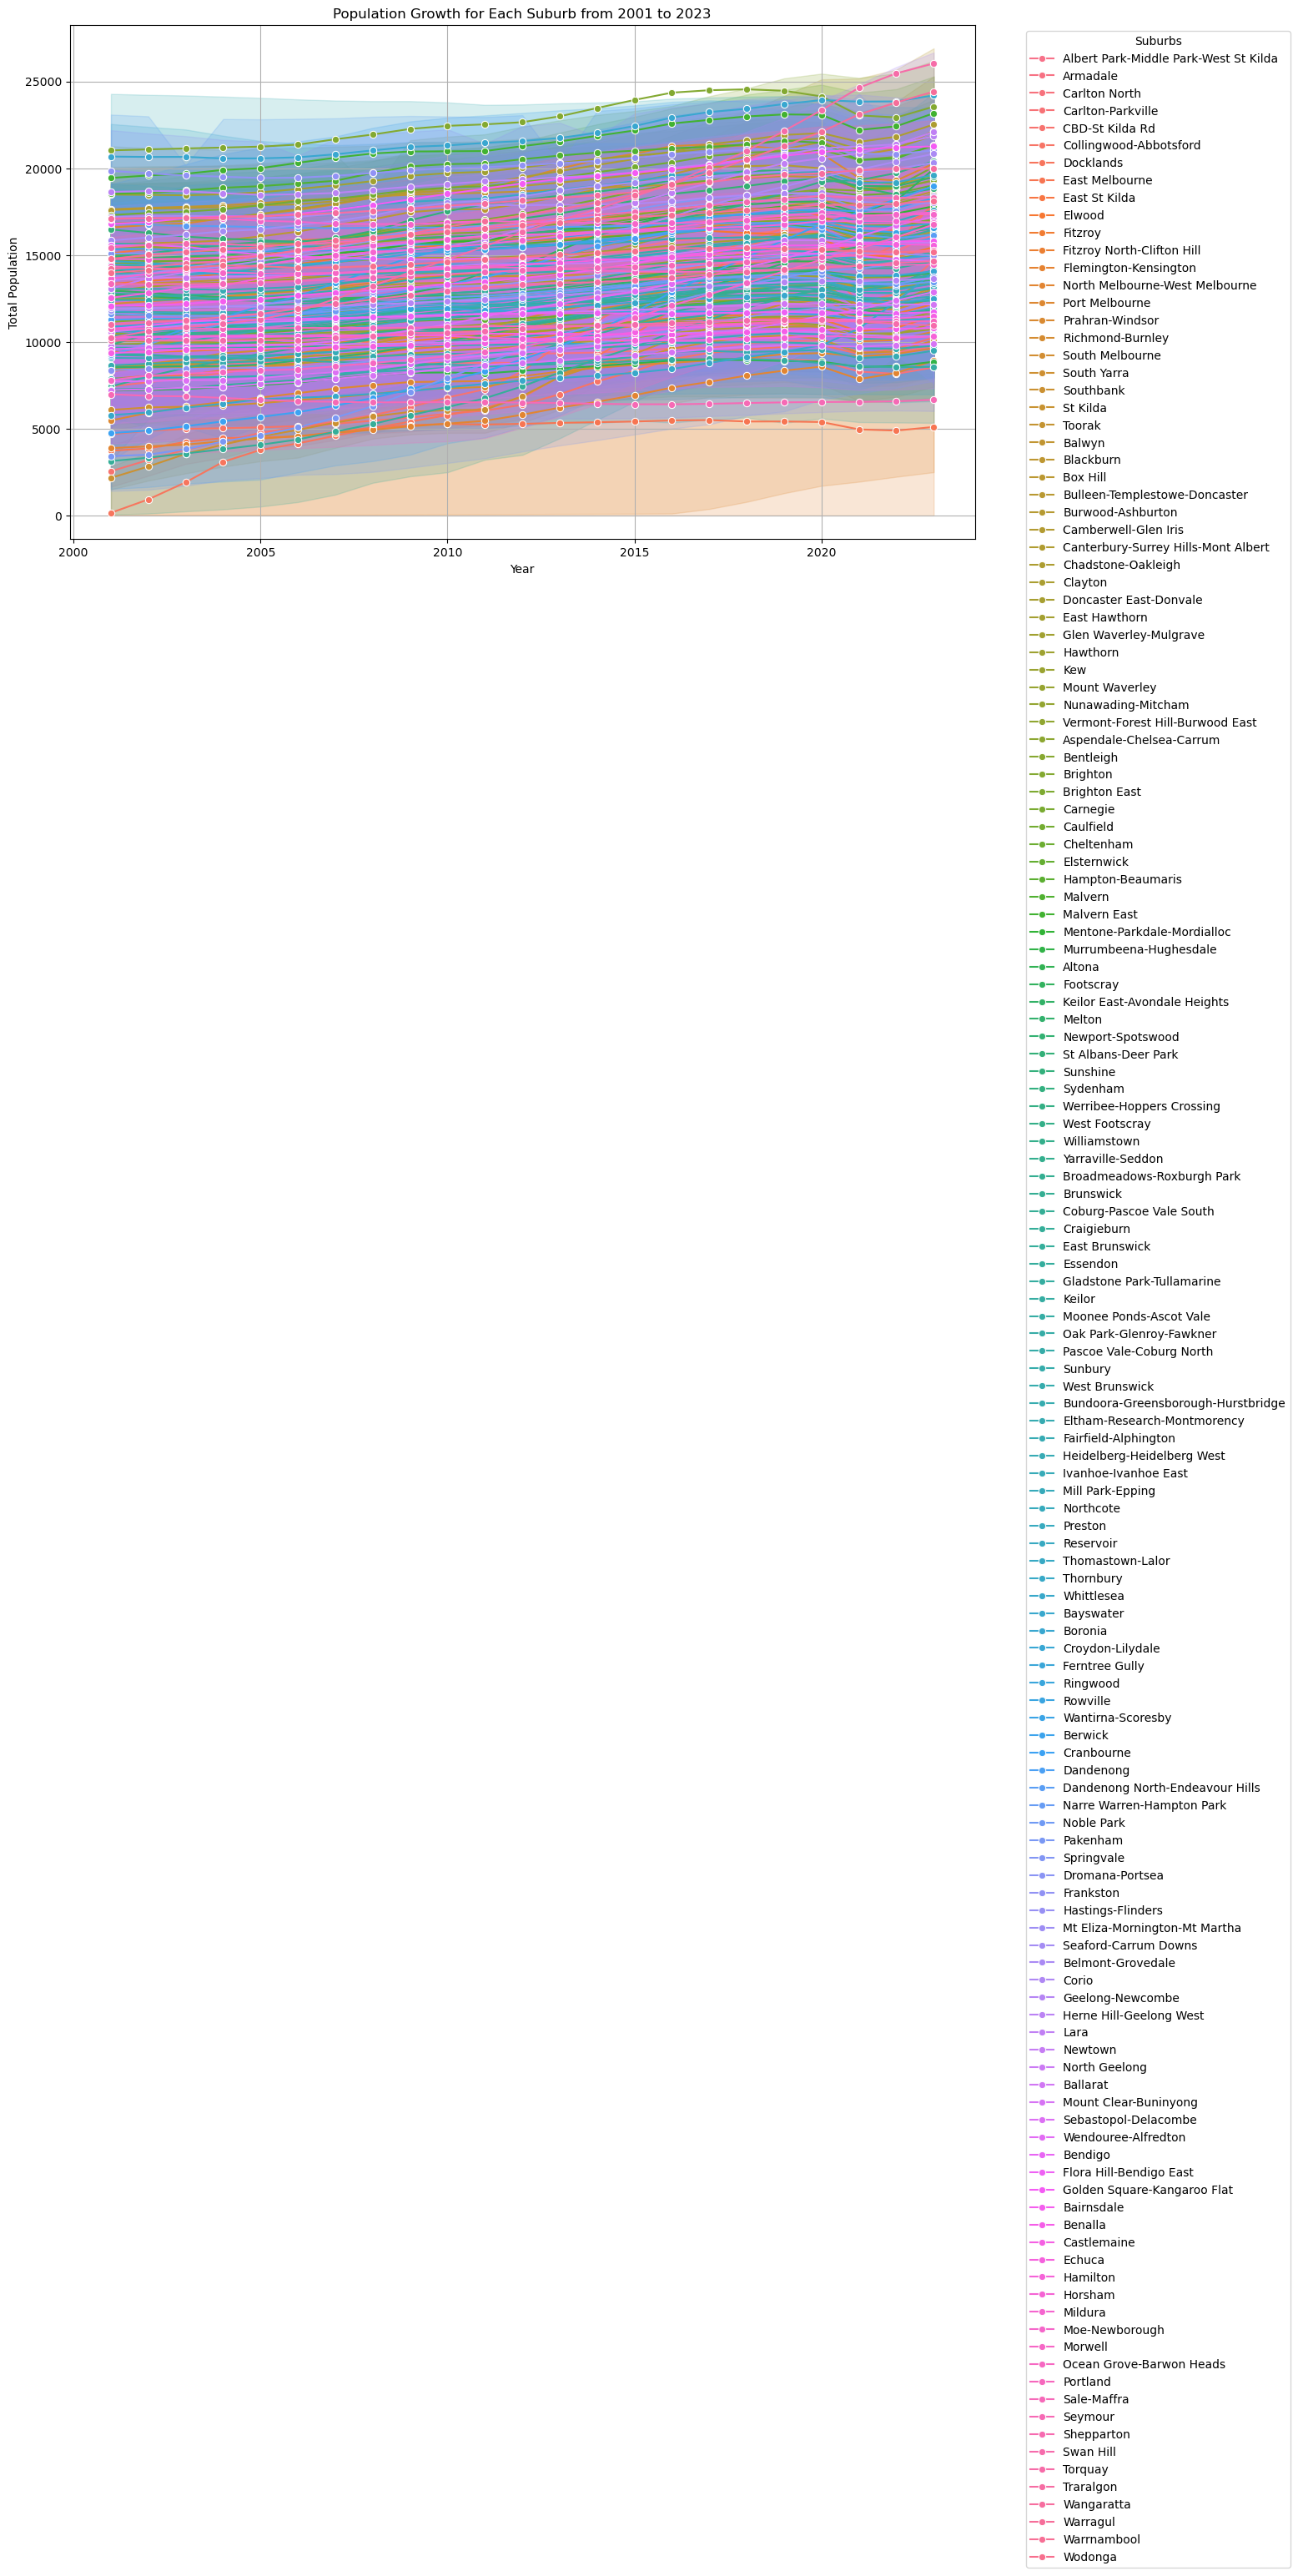

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the population growth
plt.figure(figsize=(14, 8))
sns.lineplot(data=merged_df, x='Year', y='Total persons', hue='suburbs', marker='o')

plt.title('Population Growth for Each Suburb from 2001 to 2023')
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.legend(title='Suburbs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Save the plot
plot_path = os.path.join(curated_folder, 'population_growth.png')
plt.savefig(plot_path)

# Show the plot
plt.show()

### Population forecast by suburbs

In [ ]:
forecast_population_filepath = '../../data/landing/forecast_population_sa2/VIF2023_SA2_Pop_Hhold_Dwelling_Projections_to_2036_Release_2.xlsx'
forecast_population_df = pd.read_excel(forecast_population_filepath)


print(forecast_population_df.head())